# LSTM Stock Prediction Model

In [1]:
import math
import pandas as pd
import pandas_datareader as web
import numpy as np
import datetime

import yfinance as yf

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from tensorflow.keras.models import Sequential
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import tensorflow as tf
from tensorflow import keras


### Set Datetime From 2012 Until Yesterday

In [2]:
# Get today's date
today = datetime.date.today()

# Calculate yesterday's date
yesterday = today - datetime.timedelta(days=1)

# Format yesterday's date as a string
end = yesterday.strftime('%Y-%m-%d')

# Print or use 'end' as needed
print("Yesterday's date:", end)
 


Yesterday's date: 2023-11-18


In [4]:
start = '2012-01-01'
end = yesterday.strftime('%Y-%m-%d')
stock = 'GOOG'

In [5]:
data = yf.download(stock, start, end)

data.reset_index(inplace = True)
data

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,16.262545,16.641375,16.248346,16.573130,16.573130,147611217
1,2012-01-04,16.563665,16.693678,16.453827,16.644611,16.644611,114989399
2,2012-01-05,16.491436,16.537264,16.344486,16.413727,16.413727,131808205
3,2012-01-06,16.417213,16.438385,16.184088,16.189817,16.189817,108119746
4,2012-01-09,16.102144,16.114599,15.472754,15.503389,15.503389,233776981
...,...,...,...,...,...,...,...
2985,2023-11-13,133.360001,134.110001,132.770004,133.639999,133.639999,16409900
2986,2023-11-14,135.649994,137.240005,135.100006,135.429993,135.429993,22317300
2987,2023-11-15,136.639999,136.839996,135.330002,136.380005,136.380005,15840900
2988,2023-11-16,136.960007,138.880005,136.080002,138.699997,138.699997,17615100


## Time Series Sequence Generation

### Slice The Data into Training and Test Set

In [6]:
data_train = pd.DataFrame(data.Close[0: int(len(data)*0.8)])
data_test = pd.DataFrame(data.Close[int(len(data)*0.80): len(data)])
data_train.shape, data_test.shape

((2392, 1), (598, 1))

### Scaling the Training Data


In [7]:
scaler =  MinMaxScaler(feature_range = (0,1))

### Time Series Sequence Generation

In [8]:
data_train_scale = scaler.fit_transform(data_train)

### Input-Output Pair Generation

In [9]:
x = []
y = []

for i in range(100, data_train_scale.shape[0]):
    x.append(data_train_scale[i-100:i])
    y.append(data_train_scale[i,0])

### Array Conversion for Model Input

In [10]:
x, y =np.array(x),np.array(y)

## LSTM Model 

In [11]:
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences =True,
              input_shape = ((x.shape[1],1))))
model.add(Dropout(0.2))

model.add(LSTM(units =60, activation = 'relu', return_sequences =True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80, activation = 'relu', return_sequences =True))
model.add(Dropout(0.4))

model.add(LSTM(units =120, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss= 'mean_squared_error')

In [12]:
%%time
model.fit(x,y, epochs = 50, batch_size = 32, verbose =1)

Epoch 1/50

72/72 [==============================] - 15s 131ms/step - loss: 0.0173
Epoch 2/50
72/72 [==============================] - 10s 137ms/step - loss: 0.0048
Epoch 3/50
72/72 [==============================] - 10s 136ms/step - loss: 0.0038
Epoch 4/50
72/72 [==============================] - 10s 132ms/step - loss: 0.0035
Epoch 5/50
72/72 [==============================] - 9s 130ms/step - loss: 0.0036
Epoch 6/50
72/72 [==============================] - 9s 128ms/step - loss: 0.0028
Epoch 7/50
72/72 [==============================] - 10s 142ms/step - loss: 0.0026
Epoch 8/50
72/72 [==============================] - 10s 134ms/step - loss: 0.0028
Epoch 9/50
72/72 [==============================] - 9s 131ms/step - loss: 0.0025
Epoch 10/50
72/72 [==============================] - 9s 122ms/step - loss: 0.0029
Epoch 11/50
72/72 [==============================] - 9s 119ms/step - loss: 0.0023
Epoch 12/50
72/72 [==============================] - 8s 117ms/step - loss: 0.0025
Epoch 13/50
72/72 

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_2 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

### Extracting the Last 100 Days of Training Data

In [14]:
past_100_days = data_train.tail(100)

### Combining the Last 100 Days with the Test Data

In [15]:
data_test = pd.concat([past_100_days, data_test], ignore_index = True)

### Scaling the Test Data

In [16]:
data_test_scale = scaler.fit_transform(data_test)

### Generating Input-Output Pairs for Testing

In [17]:
x = []
y = []

for i in range(100, data_test_scale.shape[0]):
    x.append(data_test_scale[i-100:i])
    y.append(data_test_scale[i,0])
    
x, y =np.array(x),np.array(y)

In [18]:
#Inverse Scaling of Model Predictions
scale = 1/scaler.scale_

In [19]:
y_predict = model.predict(x)

19/19 [==============================] - 2s 48ms/step


In [20]:
y_predict = y_predict*scale

In [21]:
y = y * scale

### Plotting Predicted and Original Prices

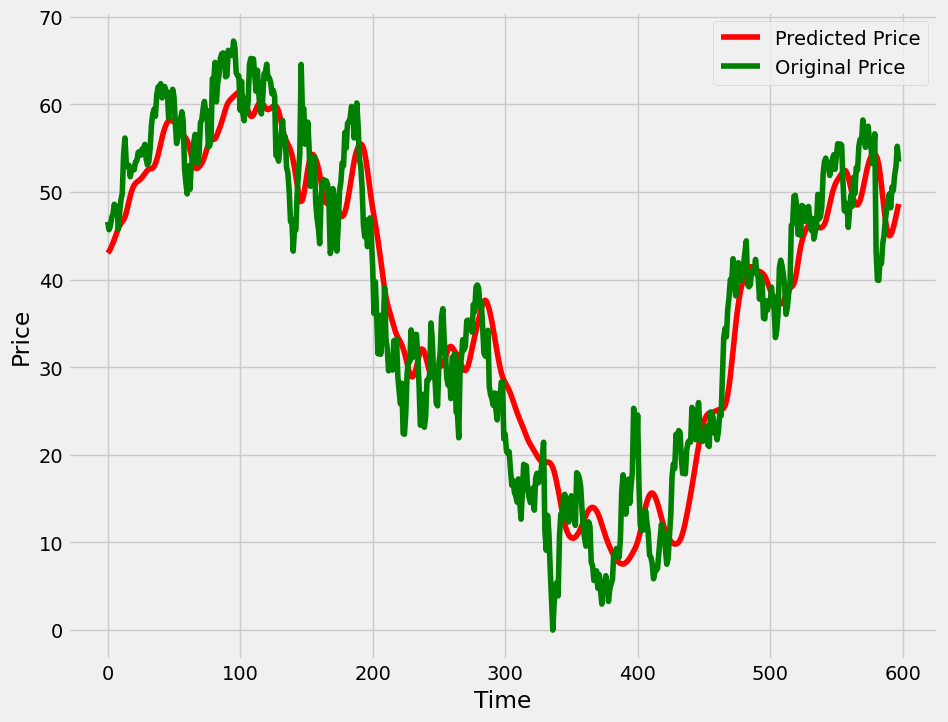

In [22]:
plt.figure(figsize = (10, 8))
plt.plot(y_predict, 'r', label = 'Predicted Price')
plt.plot(y, 'g', label = 'Original Price')

plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## Saving the Model For App Creation 

In [23]:
model.save('Stock Prediction Model.Keras')

INFO:tensorflow:Assets written to: Stock Prediction Model.Keras\assets


INFO:tensorflow:Assets written to: Stock Prediction Model.Keras\assets
